In [1]:
import os
import torch
import torch.nn as nn
import pickle
import numpy as np

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15
data = "plant"
plt.rcParams['mathtext.fontset'] = 'cm'
figpath = f'../figures/{data}'
os.makedirs(figpath, exist_ok=True)

/home/john/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
models = [
    "iid",        
    "const_and_zipfian-alpha0.7-a0.5",            
    "const_and_zipfian-alpha0.5-a0.2",    
    "zipfian-alpha0.4",    
]

labels = [
    r"$\gamma=1.0$",            
    r"$\alpha=0.7, \gamma=0.5$",
    r"$\alpha=0.5, \gamma=0.2$",    
    r"$\alpha=0.4, \gamma=0.0$",    
]

num_trials = 5

p = 2000
L = 1
lr = 1.0

results = {}

for model, label in zip(models, labels):
    results[model] = {}

    for i in range(1, num_trials + 1):
        path = os.path.join("results", data, f"{model}-p{p}-L{L}-lr{lr}/run{i}")
        gd = torch.load(os.path.join(path, "gd.th"))
        if i == 1:
            results[model]["step"] = np.array(gd["step"])
        
        for key, val in gd.items():    
            if key != "step":
                if i == 1:
                    results[model][key] = [np.array(val)]
                else:
                    results[model][key].append(np.array(val))
                    
        prune = torch.load(os.path.join(path, "prune.th"))
        if i == 1:
            results[model]["num_pruned"] = np.array(prune["num_pruned"])
        for key, val in prune.items():
            if key != "num_pruned":
                if i == 1:
                    results[model]["pruned_"+key] = [np.array(val)]
                else:
                    results[model]["pruned_"+key].append(np.array(val))
            
        transfer = torch.load(os.path.join(path, "transfer.th"))
        if i == 1:
            results[model]["feat_dim"] = np.array(transfer["feat_dim"])
        for key, val in transfer.items():
            if key != "feat_dim":
                if i == 1:
                    results[model]["transfer_"+key] = [np.array(val)]
                else:
                    results[model]["transfer_"+key].append(np.array(val))
             

    for key, val in results[model].items():
        if key not in ["step"]:
            results[model][key] = np.stack(val)

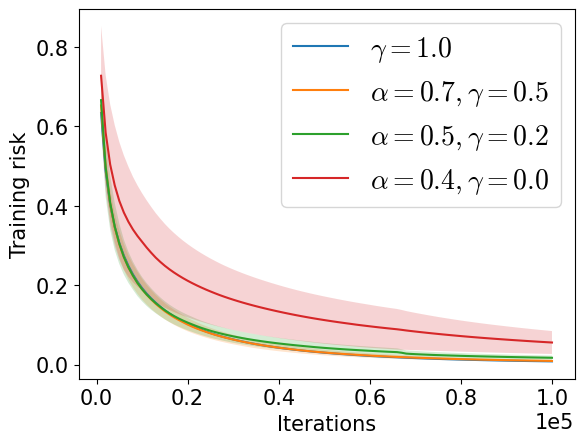

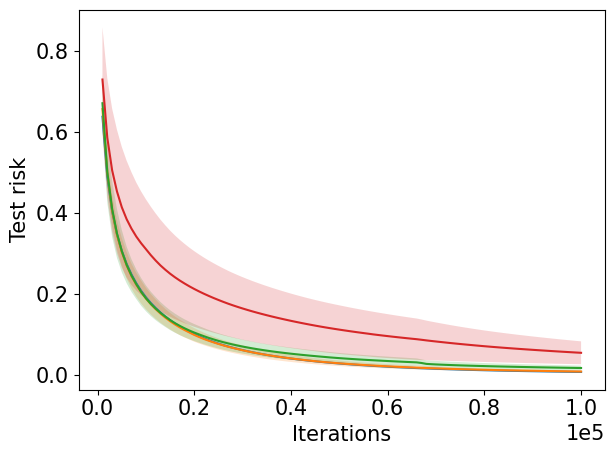

In [59]:
plt.figure()
for model, label in zip(models, labels):
    step = results[model]["step"][1:]
    val = results[model]["trainrisk"][:,1:]    
    mean, std = val.mean(0), val.std(0)    
    plt.fill_between(step, mean - std, mean + std, alpha=0.2)
    plt.plot(step, mean, label=label)
plt.xlabel("Iterations")
plt.ylabel("Training risk")
plt.legend(fontsize=20)
plt.gca().ticklabel_format(style="sci", axis="x", scilimits=(0, 2))
plt.savefig(os.path.join(figpath, "trainrisk.pdf"), bbox_inches='tight')

plt.figure()
for model, label in zip(models, labels):
    step = results[model]["step"][1:]
    val = results[model]["testrisk"][:,1:]
    mean, std = val.mean(0), val.std(0)    
    plt.fill_between(step, mean - std, mean + std, alpha=0.2)
    plt.plot(step, mean, label=label)
plt.xlabel("Iterations")
plt.ylabel("Test risk")
# plt.legend()
plt.gca().ticklabel_format(style="sci", axis="x", scilimits=(0, 2))
plt.tight_layout()
plt.savefig(os.path.join(figpath, "testrisk.pdf"), bbox_inches='tight')

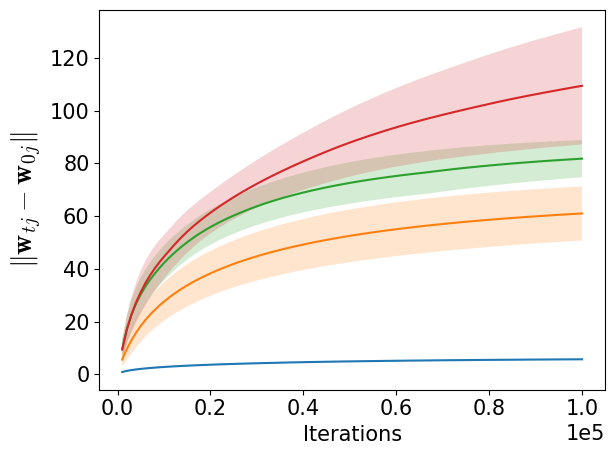

In [60]:
plt.figure()
for model, label in zip(models, labels):
    step = results[model]["step"][1:]    
    w1diff = results[model]["v1diff"][:,1:]
    max_js = w1diff[:, -1, :].argmax(-1)
    val = np.sqrt(w1diff[range(num_trials), :, max_js])
    mean, std = val.mean(0), val.std(0)    
    plt.fill_between(step, mean - std, mean + std, alpha=0.2)
    plt.plot(step, mean, label=label)
# plt.legend()
plt.xlabel("Iterations")
plt.ylabel(r"$\Vert \mathbf{w}_{tj} - \mathbf{w}_{0j}\Vert$", fontsize=20)
plt.gca().ticklabel_format(style="sci", axis="x", scilimits=(0, 2))
plt.tight_layout()
plt.savefig(os.path.join(figpath, 'wdiff.pdf'), bbox_inches='tight')

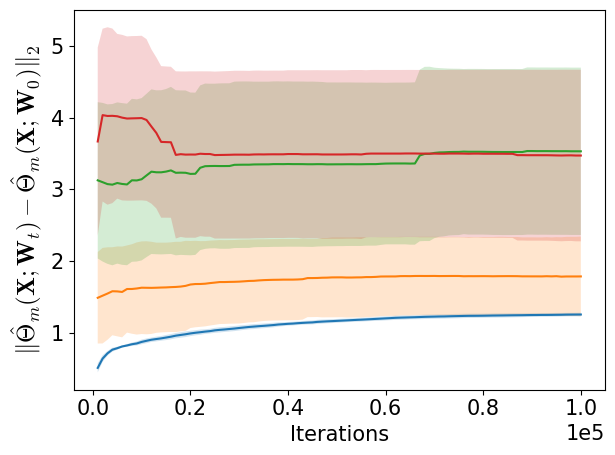

In [61]:
plt.figure()
for model, label in zip(models, labels):
    step = results[model]["step"][1:]
    ntk = results[model]["ntk"]
    ntk_diff = ntk[:, 1:] - ntk[:, 0:1]
    _, s, _ = np.linalg.svd(ntk_diff)
    val = np.sqrt(s[:, :, 0])
    mean, std = val.mean(0), val.std(0)    
    plt.fill_between(step, mean - std, mean + std, alpha=0.2)
    plt.plot(step, mean, label=label)
# plt.legend()
plt.xlabel("Iterations")
plt.ylabel(r"$\Vert \hat{\Theta}_m(\mathbf{X};\mathbf{W}_t) - \hat{\Theta}_m(\mathbf{X};\mathbf{W}_0)\Vert_2$", fontsize=18)
plt.gca().ticklabel_format(style="sci", axis="x", scilimits=(0, 2))
plt.tight_layout()
plt.savefig(os.path.join(figpath, 'ntkdiff.pdf'), bbox_inches='tight')

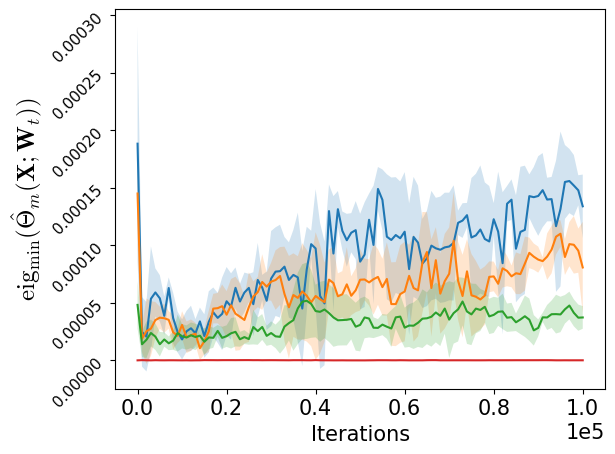

In [62]:
plt.figure()
for model, label in zip(models, labels):
    step = results[model]["step"]
    ntk_eig = results[model]["ntk_eig"]
    min_ntk_eig = ntk_eig.min(-1)       
    mean, std = min_ntk_eig.mean(0), min_ntk_eig.std(0)    
    plt.fill_between(step, mean - std, mean + std, alpha=0.2)
    plt.plot(step, mean, label=label)

# plt.legend()
plt.xlabel("Iterations")
plt.ylabel(r"$\mathrm{eig}_\min(\hat{\Theta}_m(\mathbf{X};\mathbf{W}_t))$", fontsize=18)
plt.gca().ticklabel_format(style="sci", axis="x", scilimits=(0, 2))
plt.yticks(fontsize=11, rotation=45)
# plt.gca().ticklabel_format(style="sci", axis="y", scilimits=(0, 2))
plt.tight_layout()
plt.savefig(os.path.join(figpath, 'ntkmineig.pdf'), bbox_inches='tight')

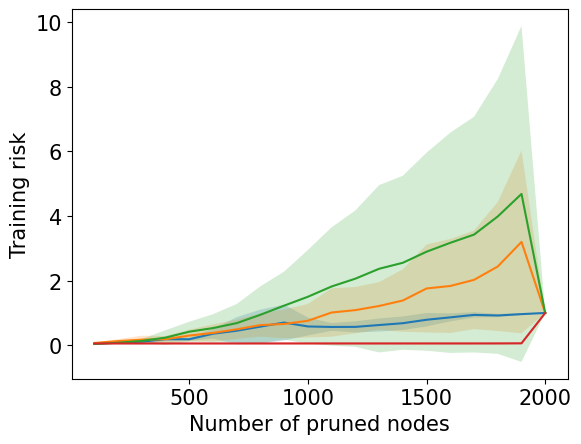

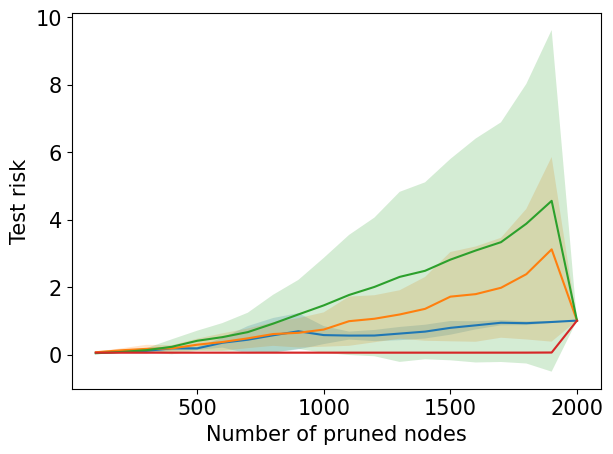

In [63]:
plt.figure()
for model, label in zip(models, labels):
    step = results[model]["num_pruned"]
    val = results[model]["pruned_trainrisk"]
    mean, std = val.mean(0), val.std(0)
    plt.fill_between(step, mean - std, mean + std, alpha=0.2)
    plt.plot(step, mean, label=label)
plt.xlabel("Number of pruned nodes")
plt.ylabel("Training risk")
# plt.legend(loc='upper left')
plt.savefig(os.path.join(figpath, "prune_trainrisk.pdf"), bbox_inches="tight")

plt.figure()
for model, label in zip(models, labels):
    step = results[model]["num_pruned"]
    val = results[model]["pruned_testrisk"]
    mean, std = val.mean(0), val.std(0)
    plt.fill_between(step, mean - std, mean + std, alpha=0.2)
    plt.plot(step, mean, label=label)
plt.xlabel("Number of pruned nodes")
plt.ylabel("Test risk")
# plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(figpath, "prune_testrisk.pdf"), bbox_inches="tight")

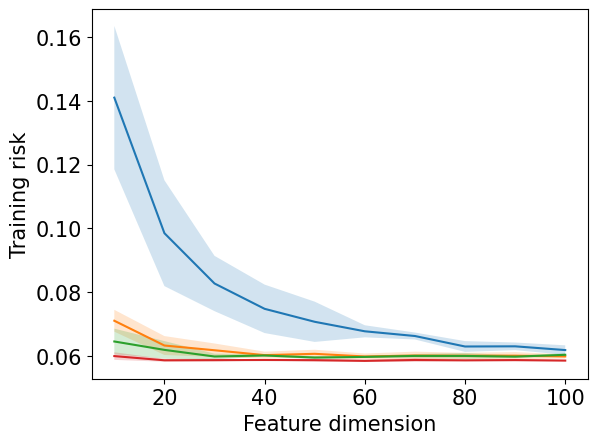

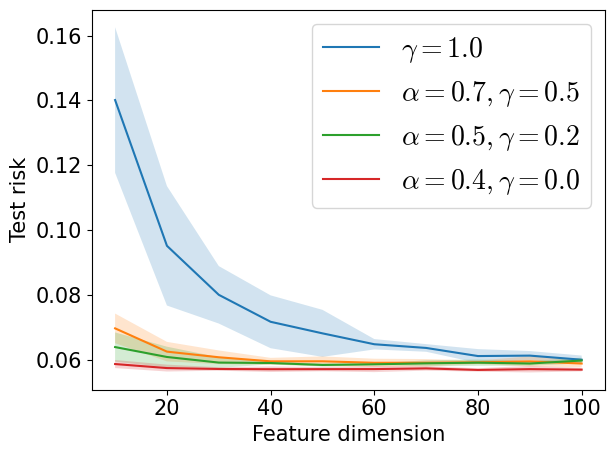

In [4]:
plt.figure()
for model, label in zip(models, labels):
    step = results[model]["feat_dim"]
    val = results[model]["transfer_trainrisk"]
    mean, std = val.mean(0), val.std(0)
    plt.fill_between(step, mean-std, mean+std, alpha=0.2)
    plt.plot(step, mean, label=label)    
plt.xlabel("Feature dimension")
plt.ylabel("Training risk")
# plt.legend()
plt.savefig(os.path.join(figpath, "transfer_trainrisk.pdf"), bbox_inches='tight')

plt.figure()
for model, label in zip(models, labels):
    step = results[model]["feat_dim"]
    val = results[model]["transfer_testrisk"]
    mean, std = val.mean(0), val.std(0)
    plt.fill_between(step, mean-std, mean+std, alpha=0.2)
    plt.plot(step, mean, label=label)    
plt.xlabel("Feature dimension")
plt.ylabel("Test risk")
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(figpath, "transfer_testrisk.pdf"), bbox_inches='tight')